# Calculating SPEI-12 for different data sets

This python script uses the xclim package to calculate one SPEI-12 for every region from 0.5 degrees input data. 

In [1]:
import xclim
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pint
from xclim import indices
from xclim.core import units
from xclim.indices import standardized_precipitation_evapotranspiration_index
import pandas as pd
import spei as si  # si for standardized index

xr.set_options(keep_attrs=True)

## Definitions

In [2]:
def SPEI_region(region_name, prec, pet, spei_period, offset, cal_start, cal_end, dir):
    # Select the region
    if region_name == "IND":
        reg_lat = slice(10,47)
        reg_lon = slice(60,110)
        region_mask = xr.open_dataarray("/scratch/6196306/masks/mask_IND.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "PAK":
        reg_lat = slice(20,40)
        reg_lon = slice(62,85)
        region_mask = xr.open_dataarray("/scratch/6196306/masks/mask_PAK.nc").sel(lat=reg_lat, lon=reg_lon)
    if region_name == "BAH": 
        reg_lat = slice(19,37) 
        reg_lon = slice(81,99)
        region_mask = xr.open_dataarray("/scratch/ruiij001/Data/Masks/mask_Brahmaputra_0_5_degrees.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "AUS":
        reg_lat = slice(-50, -10)
        reg_lon = slice(120, 165)
        region_mask = xr.open_dataarray("/scratch/6196306/masks/mask_AUS.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "WEU":
        reg_lat = slice(20, 70)
        reg_lon = slice(-30,30)
        region_mask = xr.open_dataarray("/scratch/6196306/masks/mask_WEU.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "SA":
        reg_lat = slice(-45,-12)
        reg_lon = slice(2, 50)
        region_mask = xr.open_dataarray("/scratch/6196306/masks/mask_SA.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "ARG":
        reg_lat = slice(-45, -25)
        reg_lon = slice(-75, -55)
        region_mask = xr.open_dataarray("/scratch/6196306/masks/mask_ARG.nc").sel(lat=reg_lat, lon=reg_lon)
    elif region_name == "CAL":
        reg_lat = slice(15, 60)
        reg_lon = slice(-138, -100)
        region_mask = xr.open_dataarray("/scratch/6196306/masks/mask_CAL.nc").sel(lat=reg_lat, lon=reg_lon)
    
    prec_region = prec.where(region_mask==1)
    pet_region = pet.where(region_mask==1)
    
    # Take the spatial mean over the region to calculate one SPEI
    prec_region_mean = prec_region.mean(dim = ["lon","lat"])
    pet_region_mean = pet_region.mean(dim = ["lon","lat"])
    
    # Make sure the units are in mm/d and calculate the water balance
    #pe_region_mean = prec_region_mean.sel(time = slice("1955-01-01","2022-12-31")).assign_attrs(units='mm/d') - pet_region_mean.sel(time = slice("1955-01-01","2022-12-31")).assign_attrs(units='mm/d')
    pe_region_mean = prec_region_mean.assign_attrs(units='mm/d') - pet_region_mean.assign_attrs(units='mm/d')
    print("calculating spei")
    SPEI = standardized_precipitation_evapotranspiration_index(pe_region_mean, window = spei_period, dist = "fisk",freq= "MS", offset=offset,  cal_start = cal_start, cal_end = cal_end)

    del SPEI.attrs['freq']
    del SPEI.attrs['time_indexer']
    del SPEI.attrs['units']
    del SPEI.attrs['offset']
    print("saving")
    SPEI.to_netcdf(path = "/scratch/ruiij001/Data/SPEI/0_5_degrees_apr_2024/" + dir)
    print("done")
    
    # Load the SPEI and make a figure
    SPEI12 = xr.open_dataset("/scratch/ruiij001/Data/SPEI/0_5_degrees_apr_2024/" + dir).__xarray_dataarray_variable__
    df_spei = SPEI12.to_pandas()
    
    f, ax = plt.subplots(1, 1, figsize=(16, 9), sharex=False)
    si.plot.si(df_spei[11:], ax=ax)
    [ax.set_ylabel(n, fontsize=14) for i, n in enumerate(["SPEI"])]
    
    df_pre = prec_region_mean.to_pandas()
    df_pet = pet_region_mean.to_pandas()
    df_pe = pe_region_mean.to_pandas()
    
    fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)
    df_pre[:-2].plot(ax=ax[0], legend=True, grid=True, label = "Total Precipitation (mm)").legend(loc='upper left')
    df_pet.plot(ax=ax[1], color="C1", legend=True, grid=True, label = "Potential Evapotranspiration (mm/day)")
    df_pe.plot(ax=ax[2], color="k", legend=True, grid=True, label = "PREC - PET")
    
    

# ERA5

## Load the data

Load the landmask first. The data is also over the ocean, but we don't need that.

In [3]:
landmask = xr.open_dataarray("/scratch/6196306/ERA5/land-sea-mask_0_5.nc").mean("time")

Load the total precipitation data. Note that this data is in m, and we want it in mm. So we multiply by 1000. If necesarry, resample the data to monthly. Then use the land/sea mask to filter out only the land data.

In [4]:
total_prec_mm = (xr.open_dataset("/scratch/6196306/ERA5/total_precipitation/era5_total_precipitation_1950-2023_monthly_0_5.nc").tp*1000).where(landmask>=0.5)#.resample(time="MS").mean()
total_prec_mm

<xarray.DataArray 'tp' (time: 888, lat: 360, lon: 720)>
array([[[0.14808029, 0.14808029, 0.14808029, ..., 0.14808029,
         0.14808029, 0.14808029],
        [0.14808029, 0.14808029, 0.14808029, ..., 0.14808029,
         0.14808029, 0.14808029],
        [0.13508648, 0.13508648, 0.13768673, ..., 0.13249367,
         0.13249367, 0.13249367],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.0571534 , 0.0571534 , 0.0571534 , ..., 0.0571534 ,
         0.0571534 , 0.0571534 ],
        [0.0493601 , 0.0493601 , 0.0493601 , ..., 0.0493601 ,
         0.0493601 , 0.0493601 ],
        [0.05975366, 0.05975366, 0.05975366, ..., 0.05975366,
         0.05975366, 0.05975366],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.2156198 , 0.2156198 , 0.2156198 , ..., 0.2156198 ,
         0.2156198 , 0.2156198 ],
        [0.27537346, 0.27537346, 0.27537346, ..., 0.2727732 ,
         0.27537346, 0.27537346],
        [0.3221333 , 0.3247261 , 0.32732636, ..., 0.31434   ,
         0.3169328 , 0.31953305],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-12-01
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
Attributes:
    long_name:  Total precipitation
    units:      m

Load all the PET data files. Note that this is daily data, so we resample to monthly data. Also use the land/sea mask.

In [5]:
pet = xr.open_mfdataset("/scratch/6196306/PET/PenmanMonteith/pm_fao56_*_daily_0_5_v3.nc").PM_FAO_56.where(landmask>=0.5).resample(time="1MS").mean()
pet

<xarray.DataArray 'PM_FAO_56' (time: 888, lat: 360, lon: 720)>
dask.array<transpose, shape=(888, 360, 720), dtype=float32, chunksize=(12, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-12-01

## Calculate SPEI-12

Set the offset the same as for the gridwise data. Then specify the start and the end of the calibration period. Note that the mean is now only 0 between the start and the end date. 

In [6]:
prec = total_prec_mm
pet = pet
spei_period = 12
offset = '20 mm/d'
cal_start = "1950-01-01"
cal_end = "2020-12-31"

calculating spei


/home/ruiij001/miniconda3/lib/python3.11/site-packages/xclim/indices/_agro.py:1216: UserWarning: The input data is chunked on time dimension and must be fully rechunked to run `fit` on groups . Beware, this operation can significantly increase the number of tasks dask has to handle.
  pr, _ = preprocess_standardized_index(pr, freq=freq, window=window, **indexer)
/home/ruiij001/miniconda3/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]


saving
done


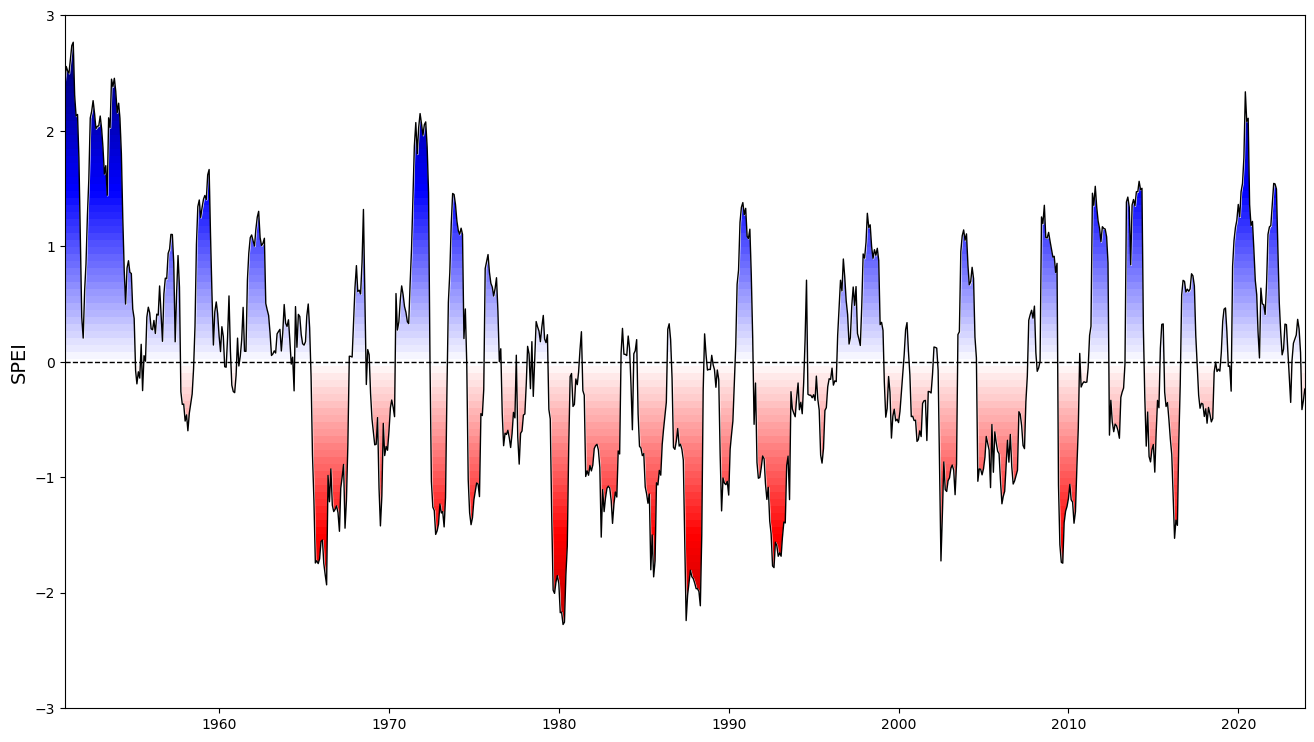

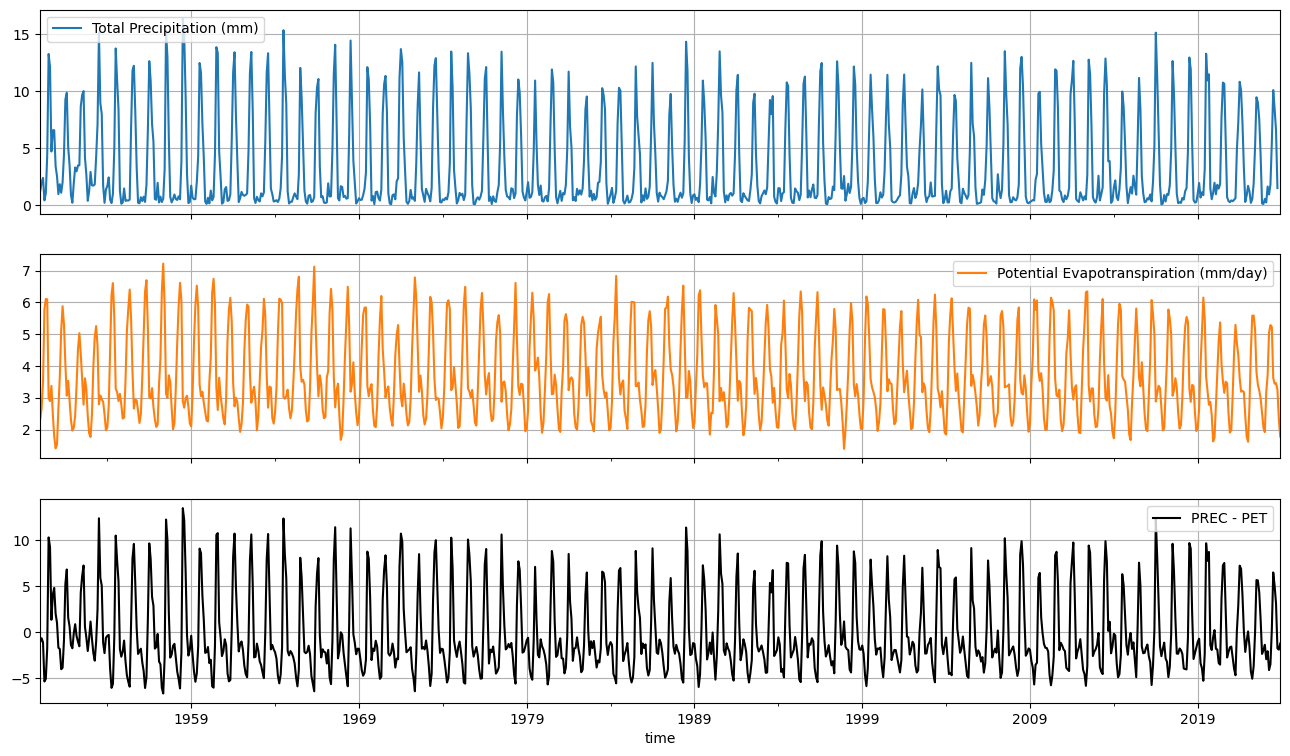

In [14]:
region_name = "IND"
dir = "SPEI12_monthly_1950_2023_0_5_degree_IND.nc"
SPEI_region(region_name, prec, pet, spei_period, offset, cal_start, cal_end, dir)

calculating spei


/home/ruiij001/miniconda3/lib/python3.11/site-packages/xclim/indices/_agro.py:1216: UserWarning: The input data is chunked on time dimension and must be fully rechunked to run `fit` on groups . Beware, this operation can significantly increase the number of tasks dask has to handle.
  pr, _ = preprocess_standardized_index(pr, freq=freq, window=window, **indexer)
/home/ruiij001/miniconda3/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]


saving
done


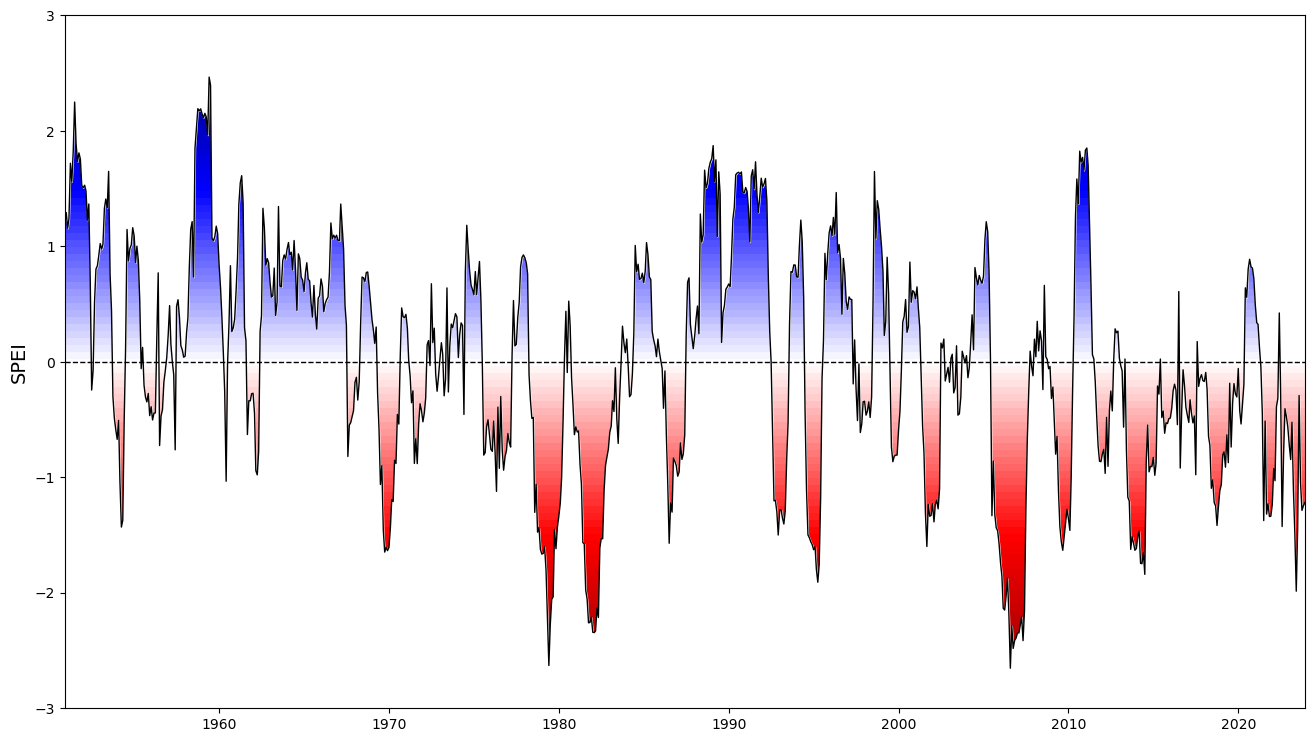

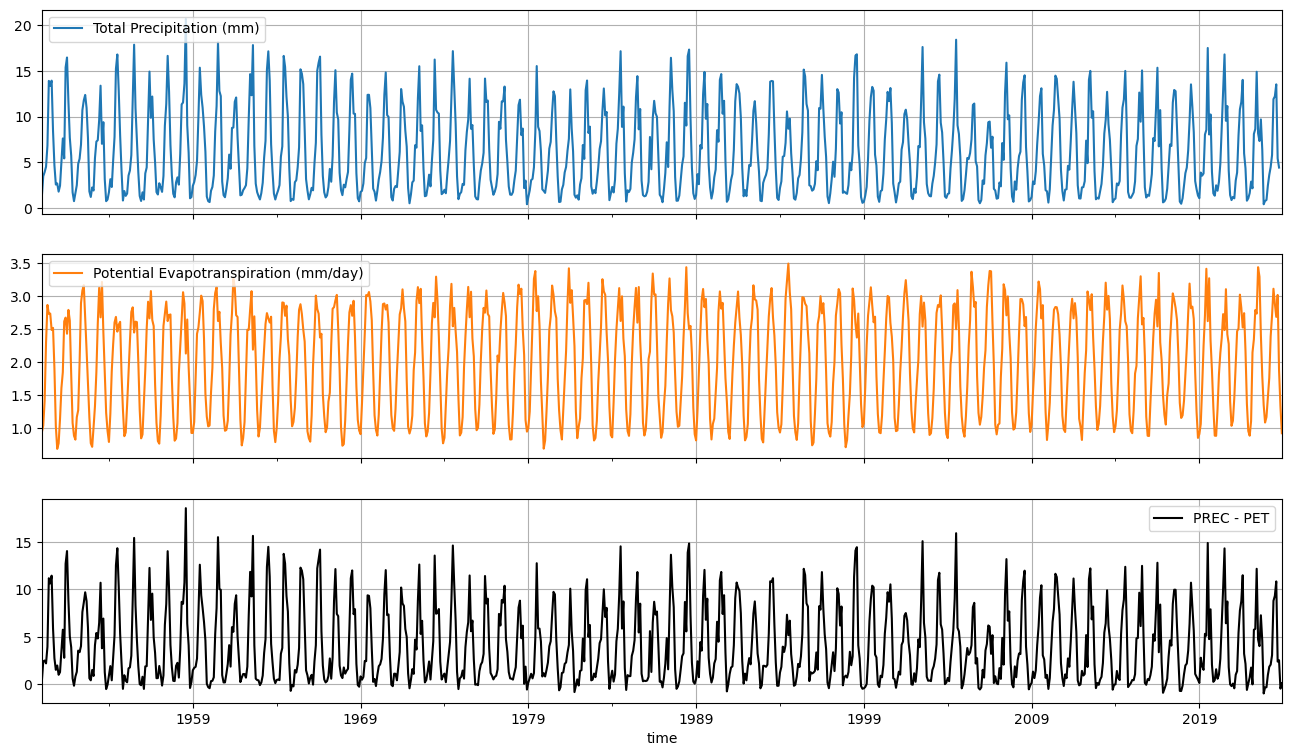

In [7]:
region_name = "BAH"
dir = "SPEI12_monthly_1950_2023_0_5_degree_BAH.nc"
SPEI_region(region_name, prec, pet, spei_period, offset, cal_start, cal_end, dir)

calculating spei


/home/ruiij001/miniconda3/lib/python3.11/site-packages/xclim/indices/_agro.py:1216: UserWarning: The input data is chunked on time dimension and must be fully rechunked to run `fit` on groups . Beware, this operation can significantly increase the number of tasks dask has to handle.
  pr, _ = preprocess_standardized_index(pr, freq=freq, window=window, **indexer)
/home/ruiij001/miniconda3/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]


saving
done


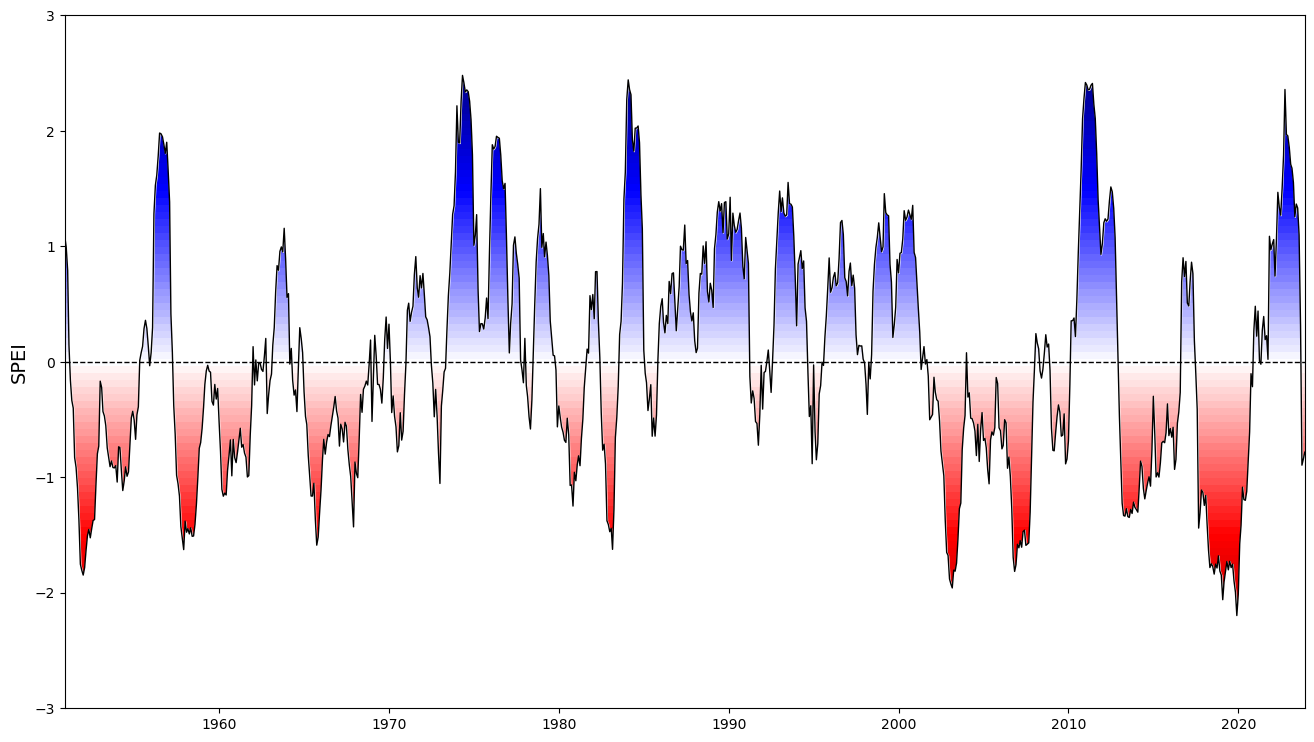

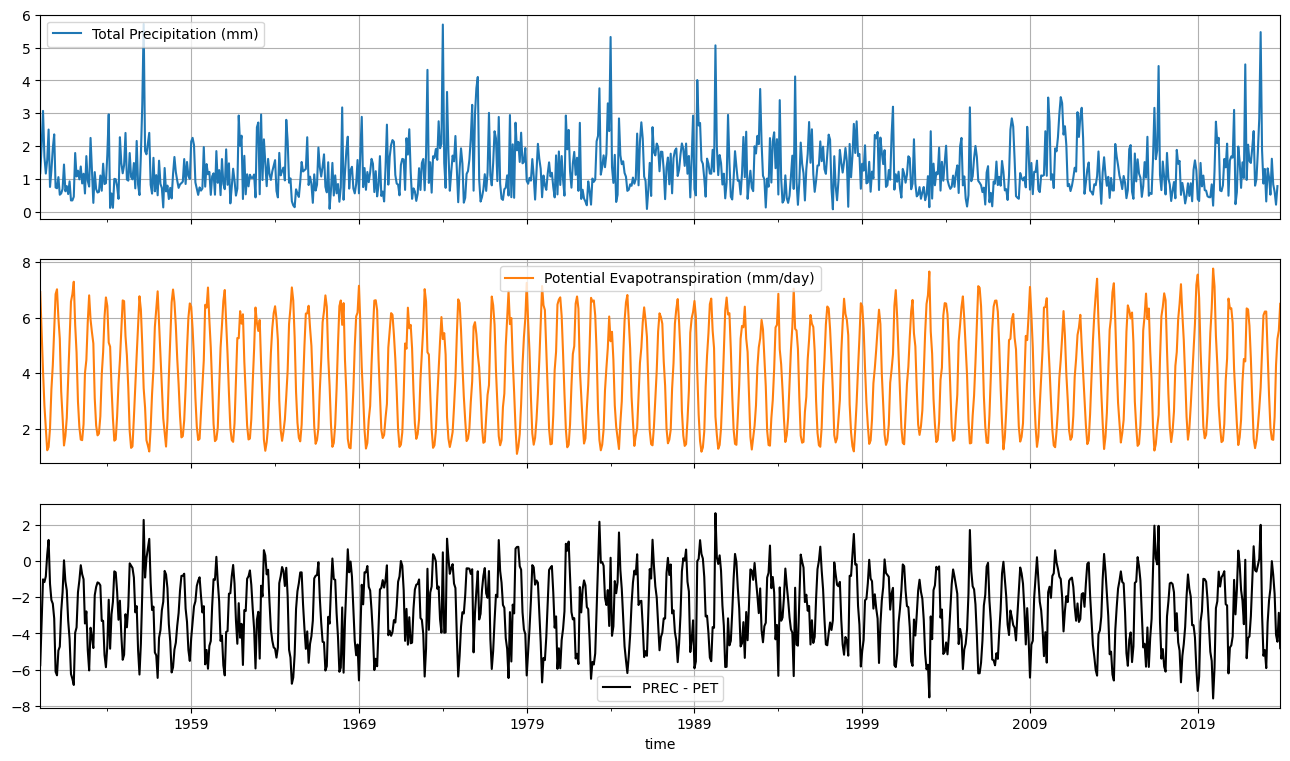

In [16]:
region_name = "AUS"
dir = "SPEI12_monthly_1950_2023_0_5_degree_AUS.nc"
SPEI_region(region_name, prec, pet, spei_period, offset, cal_start, cal_end, dir)

calculating spei


/home/ruiij001/miniconda3/lib/python3.11/site-packages/xclim/indices/_agro.py:1216: UserWarning: The input data is chunked on time dimension and must be fully rechunked to run `fit` on groups . Beware, this operation can significantly increase the number of tasks dask has to handle.
  pr, _ = preprocess_standardized_index(pr, freq=freq, window=window, **indexer)
/home/ruiij001/miniconda3/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]


saving
done


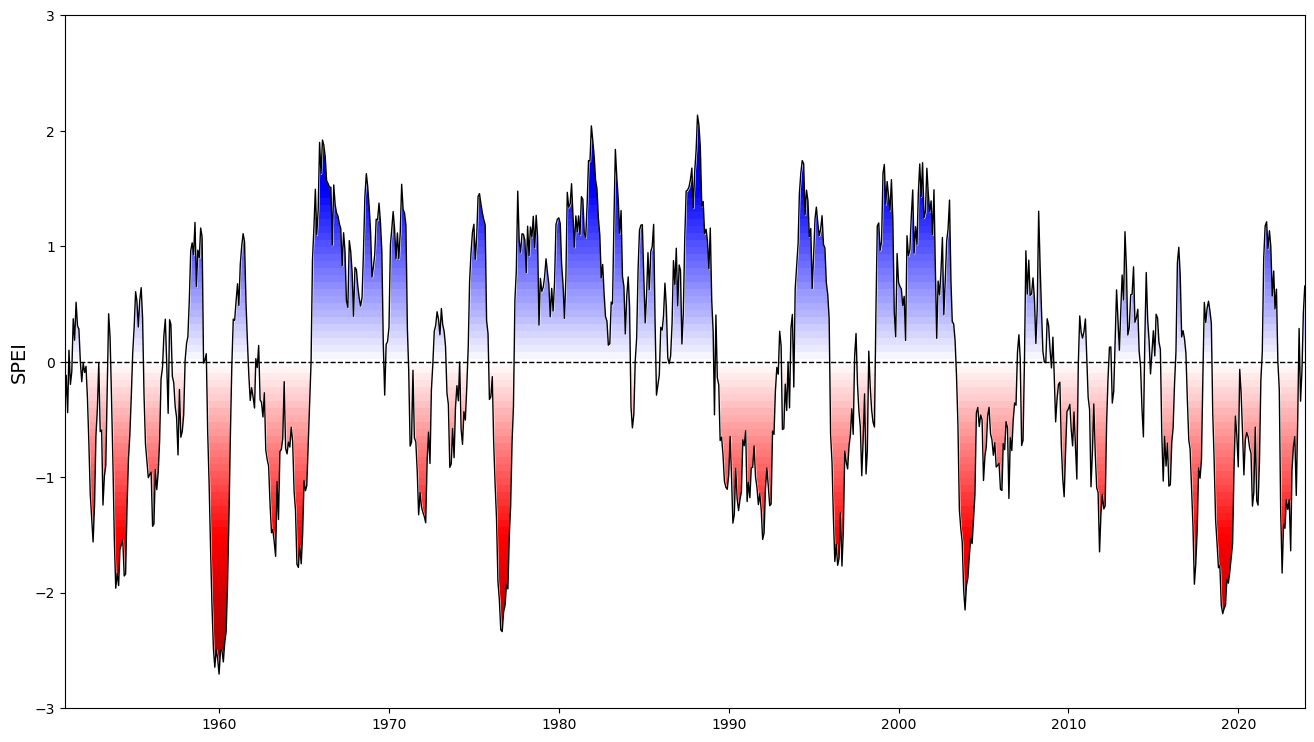

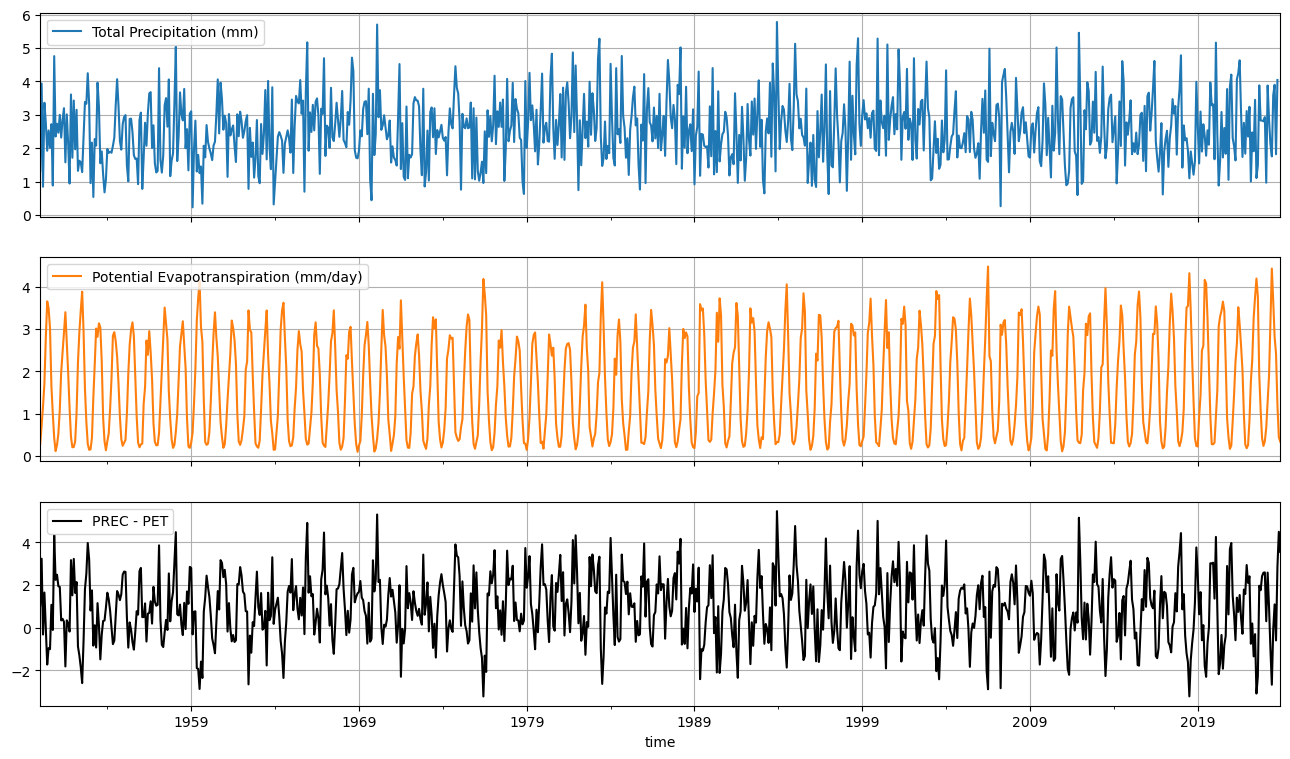

In [17]:
region_name = "WEU"
dir = "SPEI12_monthly_1950_2023_0_5_degree_WEU.nc"
SPEI_region(region_name, prec, pet, spei_period, offset, cal_start, cal_end, dir)

calculating spei


/home/ruiij001/miniconda3/lib/python3.11/site-packages/xclim/indices/_agro.py:1216: UserWarning: The input data is chunked on time dimension and must be fully rechunked to run `fit` on groups . Beware, this operation can significantly increase the number of tasks dask has to handle.
  pr, _ = preprocess_standardized_index(pr, freq=freq, window=window, **indexer)
/home/ruiij001/miniconda3/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]


saving
done


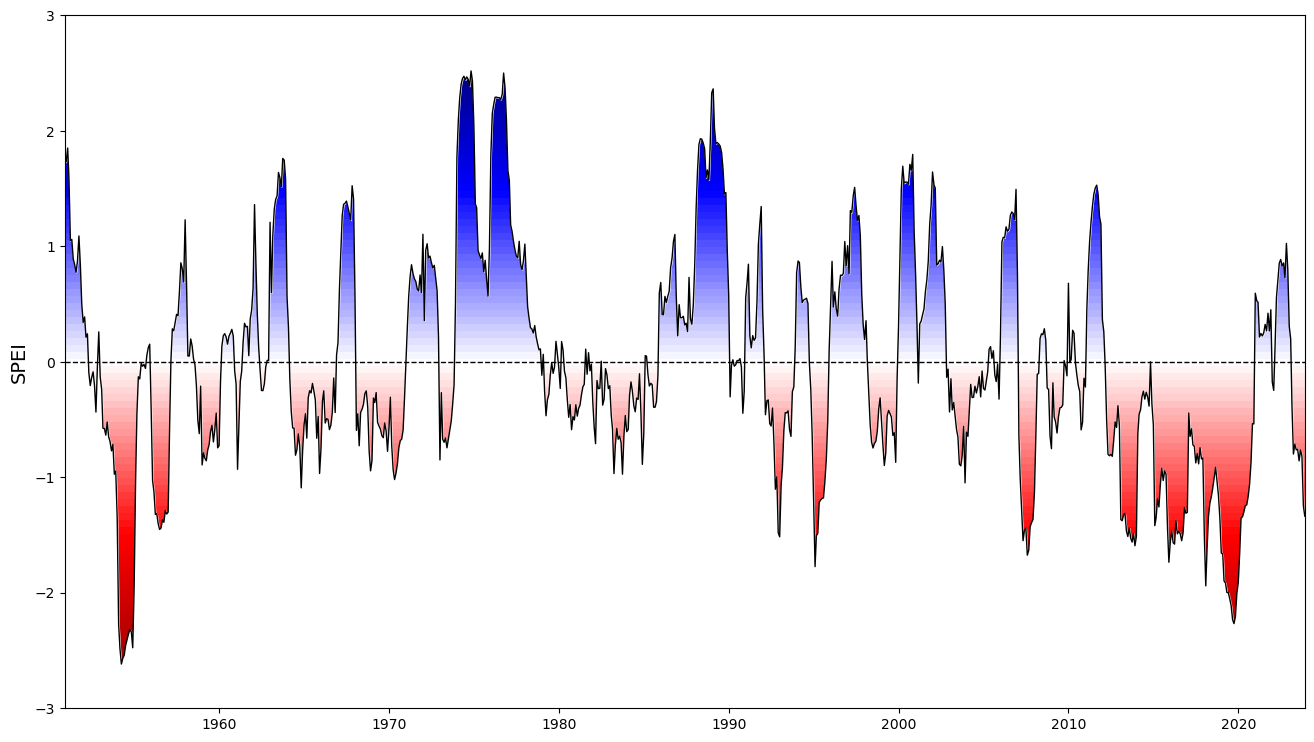

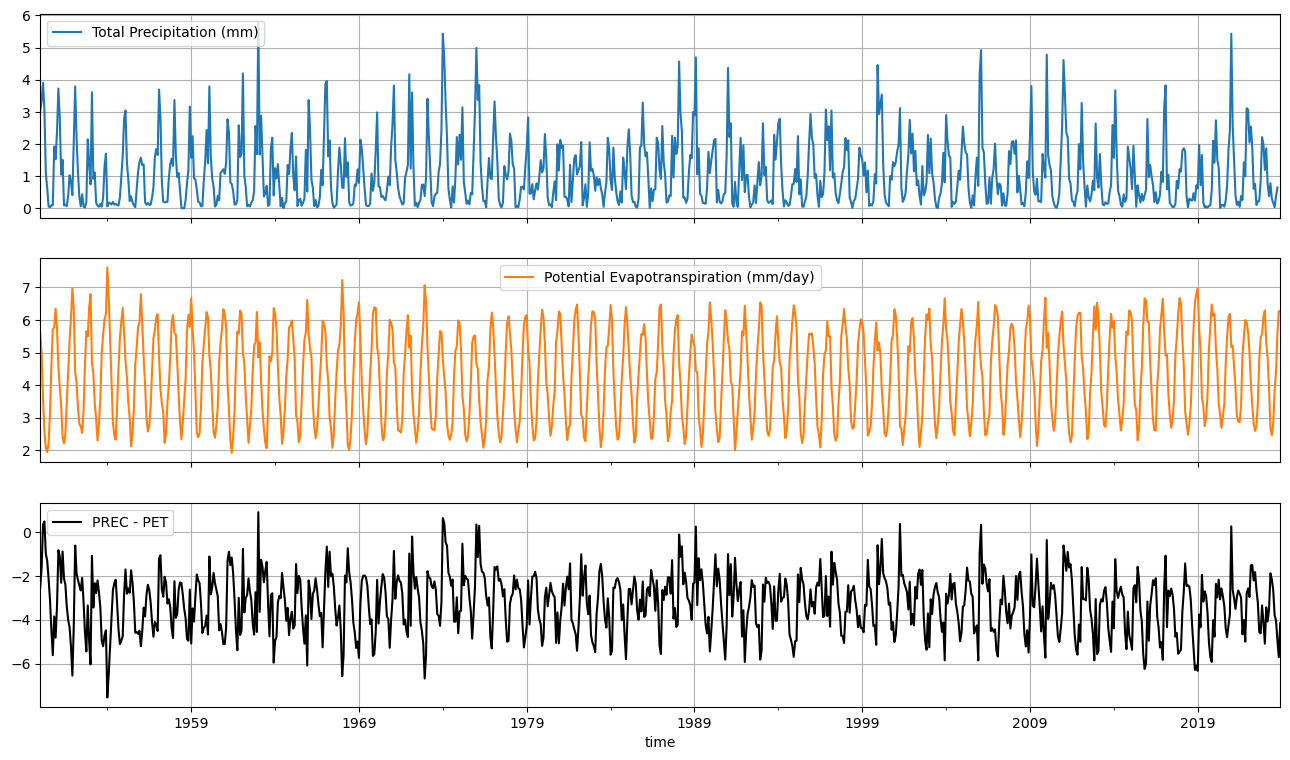

In [18]:
region_name = "SA"
dir = "SPEI12_monthly_1950_2023_0_5_degree_SA.nc"
SPEI_region(region_name, prec, pet, spei_period, offset, cal_start, cal_end, dir)

calculating spei


/home/ruiij001/miniconda3/lib/python3.11/site-packages/xclim/indices/_agro.py:1216: UserWarning: The input data is chunked on time dimension and must be fully rechunked to run `fit` on groups . Beware, this operation can significantly increase the number of tasks dask has to handle.
  pr, _ = preprocess_standardized_index(pr, freq=freq, window=window, **indexer)
/home/ruiij001/miniconda3/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]


saving
done


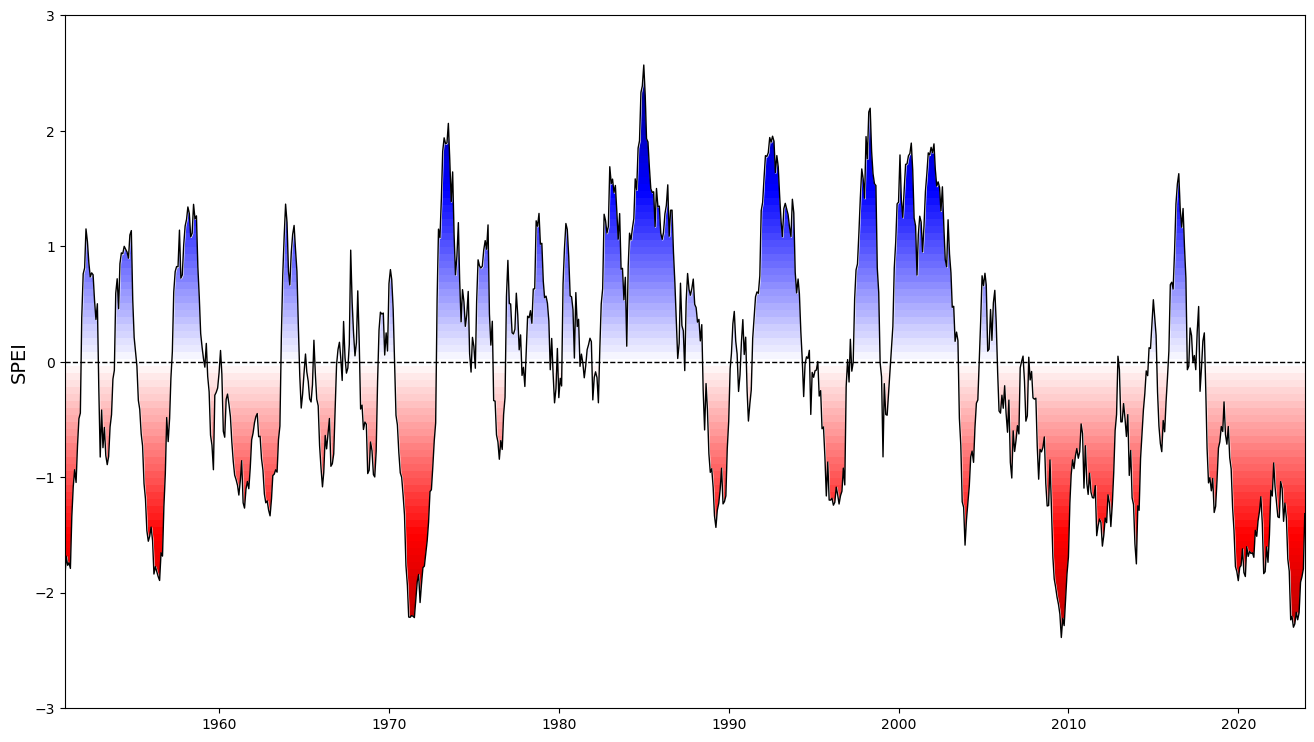

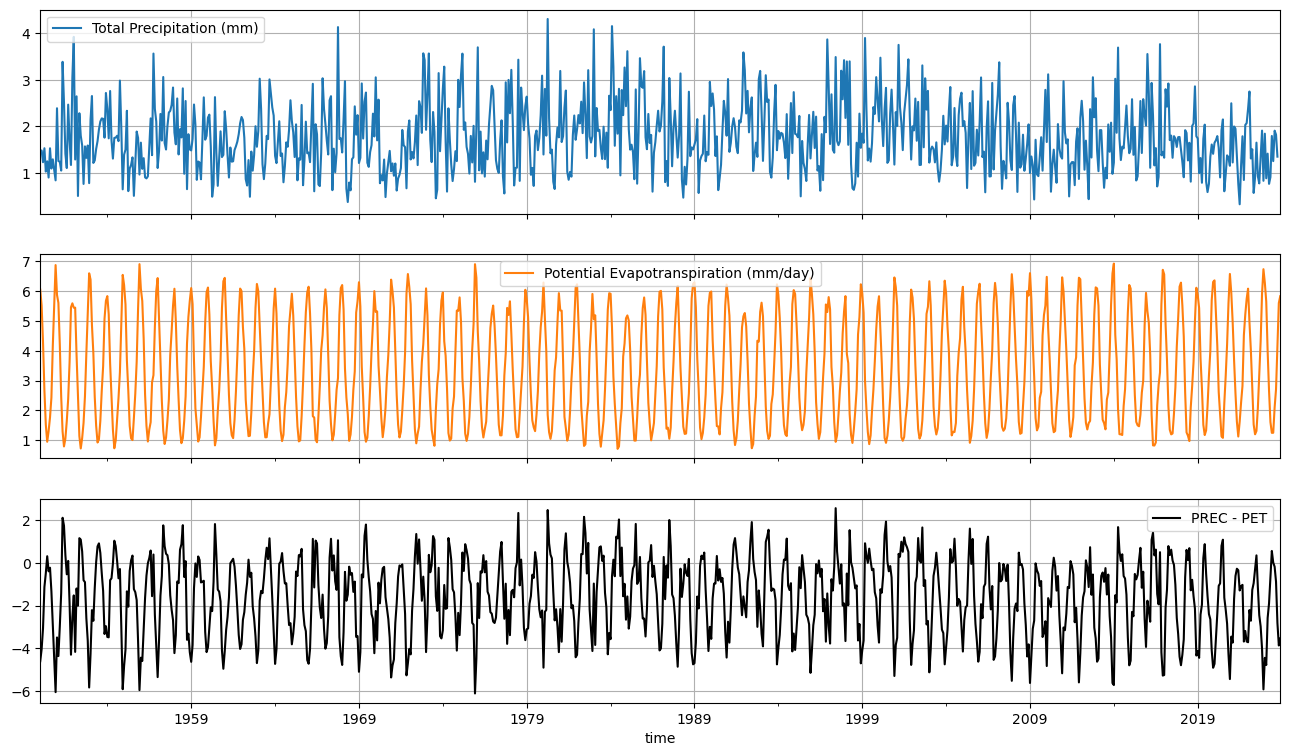

In [16]:
region_name = "ARG"
dir = "SPEI12_monthly_1950_2023_0_5_degree_ARG.nc"
SPEI_region(region_name, prec, pet, spei_period, offset, cal_start, cal_end, dir)

calculating spei


/home/ruiij001/miniconda3/lib/python3.11/site-packages/xclim/indices/_agro.py:1216: UserWarning: The input data is chunked on time dimension and must be fully rechunked to run `fit` on groups . Beware, this operation can significantly increase the number of tasks dask has to handle.
  pr, _ = preprocess_standardized_index(pr, freq=freq, window=window, **indexer)
/home/ruiij001/miniconda3/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 74 times more chunks
  return self.array[key]


saving
done


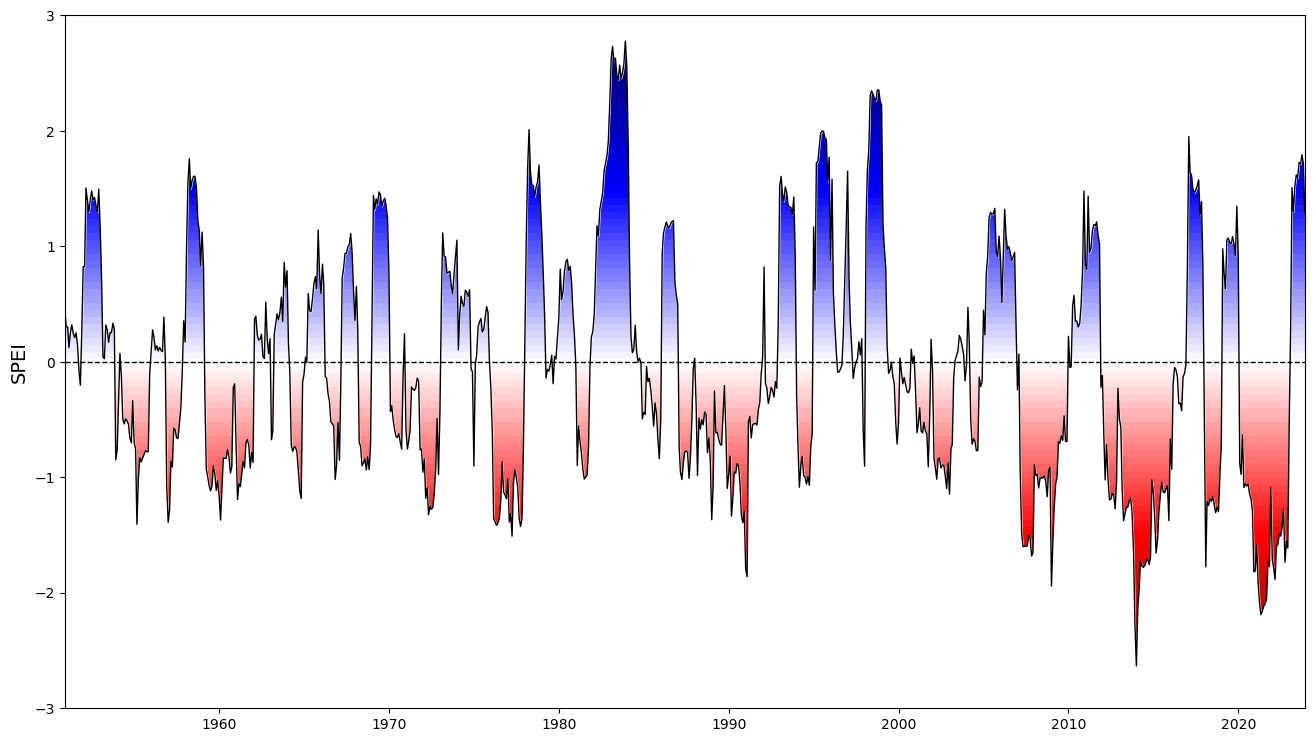

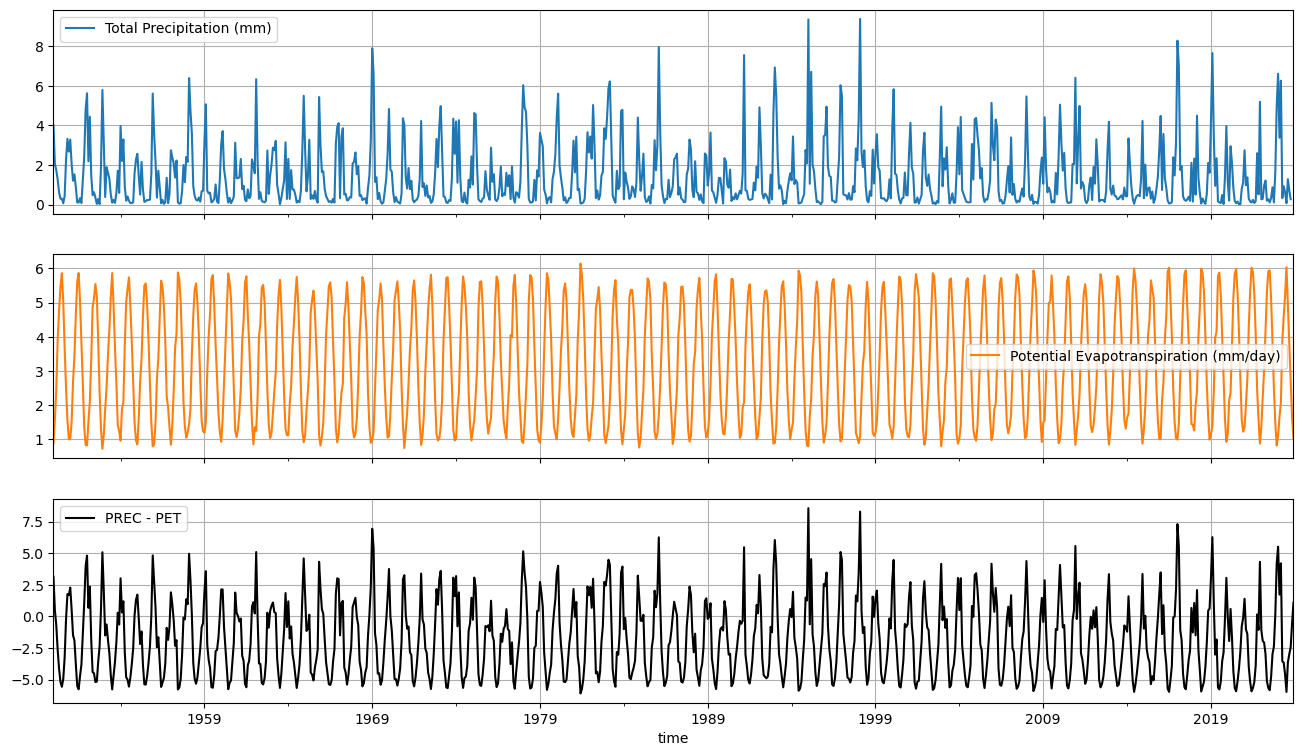

In [7]:
region_name = "CAL"
dir = "SPEI12_monthly_1950_2023_0_5_degree_CAL.nc"
SPEI_region(region_name, prec, pet, spei_period, offset, cal_start, cal_end, dir)